In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
import random

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# dataset 나누기

import os
import random
#random.seed(10)
import torchaudio
import torch
from torch.utils.data import Dataset

class SpeechCommandsDataset(Dataset):
    def __init__(self, dataset_path, keywords, subset, unknown_label, sample_ratio=0.2, noise_label='_background_noise_', num_noise_samples=100):
        self.dataset_path = dataset_path
        self.keywords = keywords
        self.unknown_label = unknown_label
        self.noise_label = noise_label
        self.num_noise_samples = num_noise_samples
        self.all_classes =self.unknown_label+ self.keywords +  [self.noise_label]
        self.subset = subset
        self.sample_ratio = sample_ratio

        self.keywords_to_index=['unknown']+self.keywords+[self.noise_label]
        
        
        # Load lists for validation and test datasets
        self.validation_list = self._load_file_list(os.path.join(dataset_path, 'validation_list.txt'))
        self.testing_list = self._load_file_list(os.path.join(dataset_path, 'testing_list.txt'))

        self.audio_files = []
        self.labels = []
        self.background_noises = []
        unknown_files = []

        # Load all audio files and corresponding labels
        for root, dirs, files in os.walk(dataset_path):
            label = os.path.basename(root)
            if label in self.all_classes:
                for file in files:
                    if file.endswith('.wav'):
                        file_path = os.path.join(root, file)
                        file_path = r"{}".format(file_path)
                        if label == noise_label: #noise append -> (txt에 있으면) unknown에 append + (txt에 있으면) audio_file에 append
                            self.background_noises.append(file_path)
                        else:
                            if label not in self.keywords: #지정 keyword (10개) 중 없는 경우 -> unknown 할당
                                label = 'unknown'
                                if self._is_in_subset(file_path):
                                    unknown_files.append((file_path, label))
                            else: 
                                if self._is_in_subset(file_path):
                                    self.audio_files.append(file_path)
                                    self.labels.append(label)

        # unknown class data를 sample_ratio(default=0.2) 비율로 sampling
        if unknown_files:
            total_desired_unknowns = int((len(self.audio_files) / (1 - self.sample_ratio)) * self.sample_ratio)
            if total_desired_unknowns < len(unknown_files):
                unknown_files = random.sample(unknown_files, total_desired_unknowns)

        # Add the sampled unknown files to the dataset
        for file_path, label in unknown_files:
            self.audio_files.append(file_path)
            self.labels.append(label)

        # Generate random slices of background noise
        self.noise_samples = []
        for _ in range(num_noise_samples):
            noise_path = random.choice(self.background_noises)
            waveform, sample_rate = torchaudio.load(noise_path)
            max_offset = waveform.size(1) - sample_rate
            offset = random.randint(0, max_offset)
            noise_slice = waveform[:, offset:offset + sample_rate]
            self.noise_samples.append(noise_slice)

    def _load_file_list(self, file_path):
        with open(file_path, 'r') as f:
            file_list = f.read().splitlines()
        return set(file_list)

    def _is_in_subset(self, file_path):
        relative_path = os.path.relpath(file_path, self.dataset_path)
        relative_path = relative_path.replace('\\', '/')
        if self.subset == 'train':
            return relative_path not in self.validation_list and relative_path not in self.testing_list
        elif self.subset == 'validation':
            return relative_path in self.validation_list
        elif self.subset == 'test':
            return relative_path in self.testing_list
        else:
            raise ValueError("Subset must be one of ['train', 'validation', 'test']")

    def _pad_waveform(self, waveform, target_length=16000):
      current_length = waveform.shape[1]
      if current_length < target_length:
        pad_amount = target_length - current_length
        padding = torch.zeros((waveform.shape[0], pad_amount))  # (channels, pad_amount)
        waveform = torch.cat((waveform, padding), dim=1)
      return waveform


    def __len__(self):
        return len(self.audio_files) + self.num_noise_samples

    def __getitem__(self, idx):

        #classes=self.all_classes ## to be fixed
        if idx < len(self.audio_files):
            file_path = self.audio_files[idx]
            label = self.labels[idx]
            label_index=self.keywords_to_index.index(label) # label to index
            waveform, sample_rate = torchaudio.load(file_path)
            waveform=self._pad_waveform(waveform) #padding
            filename = os.path.basename(file_path)
            speaker_id, utterance_number=tuple(filename.split('_nohash_'))
            utterance_number=utterance_number.split('.')[0]
        else:
            noise_idx = idx - len(self.audio_files)
            waveform = self.noise_samples[noise_idx-1]
            sample_rate = waveform.shape[1]
            label = self.noise_label
            label_index=self.keywords_to_index.index(label) # label to index
            speaker_id= None
            utterance_number=None

        return waveform, sample_rate, label_index, speaker_id, utterance_number




In [8]:
from torchaudio.datasets import SPEECHCOMMANDS

dataset = SPEECHCOMMANDS(root="./", download=True)

In [5]:
# Usage
dataset_path = r'SpeechCommands\speech_commands_v0.02'
unknown_label='backward, bed, bird, cat, dog, eight, five, follow, forward, four, happy, house, learn, marvin, nine, one, seven, sheila, six, three, tree, two, visual, wow, zero'.split(', ')
keywords = 'yes, no, up, down, left, right, on, off, stop, go'.split(', ')
num_noise_samples = 2000

if (len(unknown_label)+len(keywords)==35): #unknown과 keyword가 합쳐서 35개 되는지 확인
  # Train dataset
  train_set = SpeechCommandsDataset(dataset_path, keywords, unknown_label=unknown_label, subset='train', num_noise_samples=num_noise_samples)

  # Validation dataset
  #val_set = SpeechCommandsDataset(dataset_path, keywords, unknown_label=unknown_label, subset='validation', num_noise_samples=num_noise_samples)

  # Test dataset
  test_set = SpeechCommandsDataset(dataset_path, keywords, unknown_label=unknown_label, subset='test', num_noise_samples=num_noise_samples)
else: print("Error")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

In [9]:
print("train_set 개수 : {:}, test_set 개수 : {:}".format(len(train_set), len(test_set)))

train_set 개수 : 40461, test_set 개수 : 7092


In [10]:
from collections import Counter

label_list = []
for _, _, label, _, _ in test_set:
    label_list.append(label)

label_counts = Counter(label_list)

# 라벨과 개수 오름차순으로 출력
for label in sorted(label_counts.keys()):
    print(f"Label: {label}, Count: {label_counts[label]}")

Label: 0, Count: 1018
Label: 1, Count: 419
Label: 2, Count: 405
Label: 3, Count: 425
Label: 4, Count: 406
Label: 5, Count: 412
Label: 6, Count: 396
Label: 7, Count: 396
Label: 8, Count: 402
Label: 9, Count: 411
Label: 10, Count: 402
Label: 11, Count: 2001


Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


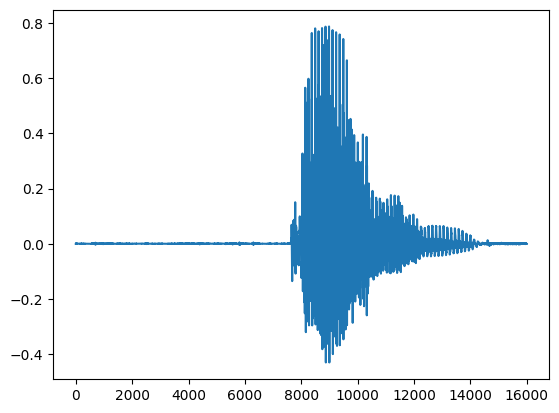

In [11]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

size of spectrogram: torch.Size([40, 61])


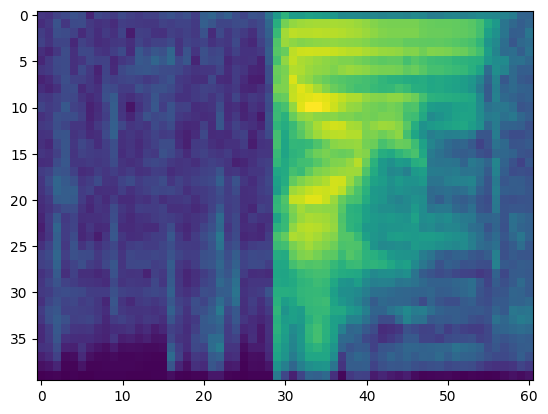

In [12]:
# spectrogram 변환
def sp_transform(waveform):

  waveform = waveform.cpu()

  spectrogram_transform = torchaudio.transforms.MelSpectrogram(sample_rate = 16000, win_length = 512, n_fft = 512, hop_length = 256, n_mels = 40, center=False)
  spectrogram = spectrogram_transform(waveform)
  epsilon = 1e-6
  spectrogram = spectrogram + epsilon
  spectrogram = spectrogram.log2()

  spectrogram = spectrogram.to(device)
  return spectrogram

sp = sp_transform(waveform)[0]
plt.imshow(sp.cpu().numpy(), aspect='auto')
print("size of spectrogram: {:}".format(sp.shape))

In [13]:
#데이터 길이 맞춰주기 위해 padding
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


# data중 waveform, label(index로 된)를 각각 tensor, target에 추가
def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.tensor(targets)
    return tensors, targets


# train, test 위한 data batch_size로 나눔
batch_size = 128

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [14]:
# Copyright (c) 2023 Qualcomm Technologies, Inc.
# All Rights Reserved.

import torch.nn.functional as F
from torch import nn



class ConvBNReLU(nn.Module):
    def __init__(
        self,
        in_plane,
        out_plane,
        idx,
        kernel_size=3,
        stride=1,
        groups=1,
        use_dilation=False,
        activation=True,
        swish=False,
        BN=True,
        ssn=False,
    ):
        super().__init__()

        def get_padding(kernel_size, use_dilation):
            rate = 1  # dilation rate
            padding_len = (kernel_size - 1) // 2
            if use_dilation and kernel_size > 1:
                rate = int(2**self.idx)
                padding_len = rate * padding_len
            return padding_len, rate

        self.idx = idx

        # padding and dilation rate
        if isinstance(kernel_size, (list, tuple)):
            padding = []
            rate = []
            for k_size in kernel_size:
                temp_padding, temp_rate = get_padding(k_size, use_dilation)
                rate.append(temp_rate)
                padding.append(temp_padding)
        else:
            padding, rate = get_padding(kernel_size, use_dilation)

        #convbnrelu block
        layers = []
        layers.append(
            nn.Conv2d(in_plane, out_plane, kernel_size, stride, (0,0), rate, groups, bias=False)
        )
        if ssn:
            if idx==1:
                layers.append(SubSpectralNorm(out_plane, spec_groups=4))
            else:
                layers.append(SubSpectralNorm(out_plane, spec_groups=3))
        elif BN:
            layers.append(nn.BatchNorm2d(out_plane))
        if swish:
            layers.append(nn.SiLU(True))
        elif activation:
            layers.append(nn.ReLU6(True))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class BCResBlock(nn.Module):
    def __init__(self, in_plane, out_plane, idx, stride):
        super().__init__()
        self.transition_block = in_plane != out_plane
        kernel_size = (3, 3)

        # 2D part (f2)
        layers = []
        if self.transition_block:
            layers.append(ConvBNReLU(in_plane, out_plane, idx, 1, 1))
            in_plane = out_plane
        layers.append(
            ConvBNReLU(
                in_plane,
                out_plane,
                idx,
                (kernel_size[0], 1),
                (2, 1),
                groups=in_plane,
                use_dilation=False,
                ssn=True, # modified
                activation=False,
            )
        )
        self.f2 = nn.Sequential(*layers)
        self.avg_gpool = nn.AdaptiveAvgPool2d((1, 61))

        # 1D part (f1)
        self.f1 = nn.Sequential(
            ConvBNReLU(
                out_plane,
                out_plane,
                idx,
                (1, kernel_size[1]),
                (1, 1),
                groups=out_plane,
                swish=False,
                use_dilation=False,
            ),
            nn.Conv2d(out_plane, out_plane, 1, bias=False), # is this necessary?
            nn.Dropout2d(0.1),
        )

    def forward(self, x):
        # 2D part
        shortcut = x
        x = self.f2(x)
        aux_2d_res = x
        x = self.avg_gpool(x)

        # 1D part
        x = self.f1(x)
        x = x + aux_2d_res
        if not self.transition_block:
            x = x + shortcut
        x = F.relu6(x, True)
        return x


def BCBlockStage(num_layers, last_channel, cur_channel, idx, use_stride):
    stage = nn.ModuleList()
    channels = [last_channel] + [cur_channel] * num_layers
    for i in range(num_layers):
        stride = (2, 1) if use_stride and i == 0 else (1, 1)
        stage.append(BCResBlock(channels[i], channels[i + 1], idx, stride))
    return stage


class BCResNets(nn.Module):
    def __init__(self, base_c, num_classes=12):
        super().__init__()
        self.num_classes = num_classes
        self.n = [1, 1, 1]  # identical modules repeated n times
        self.c = [
            int(base_c * 2),
            base_c,
            int(base_c * 2),
            base_c * 3,
            #int(base_c * 2.5),
            base_c * 4,
        ]  # num channels
        self.s = []  # stage using stride
        self._build_network()

    def _build_network(self):
        # Head: (Conv-BN-ReLU)
        self.cnn_head = nn.Sequential(
            nn.Conv2d(1, self.c[0], 3, (1, 1), 0, bias=False), #padding=2
            nn.BatchNorm2d(self.c[0]),
            nn.ReLU6(True),
        )
        # Body: BC-ResBlocks
        self.BCBlocks = nn.ModuleList([])
        for idx, n in enumerate(self.n):
            use_stride = idx in self.s
            self.BCBlocks.append(BCBlockStage(n, self.c[idx], self.c[idx + 1], idx, use_stride))

        # Classifier
        self.classifier = nn.Sequential(
            #nn.Conv2d(
            #    self.c[-2], self.c[-2], (5, 5), bias=False, groups=self.c[-2], padding=(0, 2)
            #),
            #nn.Conv2d(self.c[-2], self.c[-1], 1, bias=False),
            #nn.BatchNorm2d(self.c[-1]),
            #nn.ReLU6(True),
            #nn.AdaptiveAvgPool2d((1, 1)),
            #nn.Conv2d(self.c[-1], self.num_classes, 1),

            #nn.Conv2d(self.c[-2], self.c[-1], kernel_size=1),
            nn.BatchNorm2d(self.c[-2]),
            nn.Conv2d(self.c[-2], self.num_classes, kernel_size=1),
            nn.AdaptiveAvgPool2d(1),
        )

    def forward(self, x):
        x = self.cnn_head(x)
        for i, num_modules in enumerate(self.n):
            for j in range(num_modules):
                x = self.BCBlocks[i][j](x)
        x = self.classifier(x)
        x = x.view(-1, x.shape[1])
        return x

class SubSpectralNorm(nn.Module):
    def __init__(self, num_features, spec_groups=16, affine="Sub", batch=True, dim=2):
        super().__init__()
        self.spec_groups = spec_groups
        self.affine_all = False
        affine_norm = False
        if (
            affine == "Sub"
        ):  # affine transform for each sub group. use affine of torch implementation
            affine_norm = True
        elif affine == "All":
            self.affine_all = True
            self.weight = nn.Parameter(torch.ones((1, num_features, 1, 1)))
            self.bias = nn.Parameter(torch.zeros((1, num_features, 1, 1)))
        if batch:
            self.ssnorm = nn.BatchNorm2d(num_features * spec_groups, affine=affine_norm)
        else:
            self.ssnorm = nn.InstanceNorm2d(num_features * spec_groups, affine=affine_norm)
        self.sub_dim = dim

    def forward(self, x):  # when dim h is frequency dimension
        if self.sub_dim in (3, -1):
            x = x.transpose(2, 3)
            x = x.contiguous()
        b, c, h, w = x.size()
        assert h % self.spec_groups == 0
        x = x.view(b, c * self.spec_groups, h // self.spec_groups, w) 
        x = self.ssnorm(x)
        x = x.view(b, c, h, w)
        if self.affine_all:
            x = x * self.weight + self.bias
        if self.sub_dim in (3, -1):
            x = x.transpose(2, 3)
            x = x.contiguous()
        return x


In [15]:

num_kw=len(keywords)
model=BCResNets(base_c=8, num_classes=num_kw+2)
model.to("cuda")


BCResNets(
  (cnn_head): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (BCBlocks): ModuleList(
    (0): ModuleList(
      (0): BCResBlock(
        (f2): Sequential(
          (0): ConvBNReLU(
            (block): Sequential(
              (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU6(inplace=True)
            )
          )
          (1): ConvBNReLU(
            (block): Sequential(
              (0): Conv2d(8, 8, kernel_size=(3, 1), stride=(2, 1), groups=8, bias=False)
              (1): SubSpectralNorm(
                (ssnorm): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
            )
          )
        )
        (avg_gpool): Adaptive

In [18]:
from thop import profile
input = torch.randn(1, 1, 40, 61).to(device)
macs, params = profile(model, inputs=(input, ))
print("number of MACs: {:}, number of parameters: {:}".format(macs, params))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU6'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
number of MACs: 1563608.0, number of parameters: 2860.0


In [19]:
print(model)

BCResNets(
  (cnn_head): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (BCBlocks): ModuleList(
    (0): ModuleList(
      (0): BCResBlock(
        (f2): Sequential(
          (0): ConvBNReLU(
            (block): Sequential(
              (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU6(inplace=True)
            )
          )
          (1): ConvBNReLU(
            (block): Sequential(
              (0): Conv2d(8, 8, kernel_size=(3, 1), stride=(2, 1), groups=8, bias=False)
              (1): SubSpectralNorm(
                (ssnorm): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
            )
          )
        )
        (avg_gpool): Adaptive

In [20]:
model.train()

BCResNets(
  (cnn_head): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (BCBlocks): ModuleList(
    (0): ModuleList(
      (0): BCResBlock(
        (f2): Sequential(
          (0): ConvBNReLU(
            (block): Sequential(
              (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU6(inplace=True)
            )
          )
          (1): ConvBNReLU(
            (block): Sequential(
              (0): Conv2d(8, 8, kernel_size=(3, 1), stride=(2, 1), groups=8, bias=False)
              (1): SubSpectralNorm(
                (ssnorm): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
            )
          )
        )
        (avg_gpool): Adaptive

In [21]:
import numpy as np
total_epoch = 100
warmup_epoch = 5
init_lr = 1e-1
lr_lower_limit = 0

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0, weight_decay=1e-3, momentum=0.9)
n_step_warmup = len(train_loader) * warmup_epoch
total_iter = len(train_loader) * total_epoch
iterations = 0

losses=[]
# train
for epoch in range(total_epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for sample in tqdm(train_loader, desc="epoch %d, iters" % (epoch + 1)):
        # lr cos schedule
        iterations += 1
        if iterations < n_step_warmup:
            lr = init_lr * iterations / n_step_warmup
        else:
            lr = lr_lower_limit + 0.5 * (init_lr - lr_lower_limit) * (
                1
                + np.cos(
                    np.pi * (iterations - n_step_warmup) / (total_iter - n_step_warmup)
                )
            )
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

        inputs, labels = sample
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs = sp_transform(inputs)
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()
        model.zero_grad()

        # Track loss
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Calculate and print epoch loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total
    print(f"Epoch {epoch+1}/{total_epoch} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_accuracy:.2f}%")
    losses.append(epoch_loss)


epoch 1, iters: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]


Epoch 1/100 - Loss: 2.2799 - Accuracy: 20.96%


epoch 2, iters: 100%|██████████| 317/317 [00:39<00:00,  8.10it/s]


Epoch 2/100 - Loss: 1.4892 - Accuracy: 50.68%


epoch 3, iters: 100%|██████████| 317/317 [00:36<00:00,  8.67it/s]


Epoch 3/100 - Loss: 0.8611 - Accuracy: 72.52%


epoch 4, iters: 100%|██████████| 317/317 [00:40<00:00,  7.82it/s]


Epoch 4/100 - Loss: 0.6293 - Accuracy: 79.81%


epoch 5, iters: 100%|██████████| 317/317 [01:26<00:00,  3.67it/s]


Epoch 5/100 - Loss: 0.5637 - Accuracy: 81.81%


epoch 6, iters: 100%|██████████| 317/317 [01:30<00:00,  3.49it/s]


Epoch 6/100 - Loss: 0.5129 - Accuracy: 83.56%


epoch 7, iters: 100%|██████████| 317/317 [01:22<00:00,  3.84it/s]


Epoch 7/100 - Loss: 0.4806 - Accuracy: 84.69%


epoch 8, iters: 100%|██████████| 317/317 [01:04<00:00,  4.93it/s]


Epoch 8/100 - Loss: 0.4650 - Accuracy: 85.29%


epoch 9, iters: 100%|██████████| 317/317 [00:37<00:00,  8.52it/s]


Epoch 9/100 - Loss: 0.4517 - Accuracy: 85.72%


epoch 10, iters: 100%|██████████| 317/317 [00:37<00:00,  8.57it/s]


Epoch 10/100 - Loss: 0.4807 - Accuracy: 84.86%


epoch 11, iters: 100%|██████████| 317/317 [00:37<00:00,  8.54it/s]


Epoch 11/100 - Loss: 0.4439 - Accuracy: 85.96%


epoch 12, iters: 100%|██████████| 317/317 [00:37<00:00,  8.54it/s]


Epoch 12/100 - Loss: 0.4506 - Accuracy: 85.69%


epoch 13, iters: 100%|██████████| 317/317 [00:37<00:00,  8.52it/s]


Epoch 13/100 - Loss: 0.4244 - Accuracy: 86.54%


epoch 14, iters: 100%|██████████| 317/317 [00:36<00:00,  8.64it/s]


Epoch 14/100 - Loss: 0.4157 - Accuracy: 87.10%


epoch 15, iters: 100%|██████████| 317/317 [00:36<00:00,  8.72it/s]


Epoch 15/100 - Loss: 0.4465 - Accuracy: 86.00%


epoch 16, iters: 100%|██████████| 317/317 [00:43<00:00,  7.26it/s]


Epoch 16/100 - Loss: 0.4071 - Accuracy: 87.22%


epoch 17, iters: 100%|██████████| 317/317 [00:53<00:00,  5.93it/s]


Epoch 17/100 - Loss: 0.4249 - Accuracy: 86.61%


epoch 18, iters: 100%|██████████| 317/317 [00:52<00:00,  6.01it/s]


Epoch 18/100 - Loss: 0.4241 - Accuracy: 86.52%


epoch 19, iters: 100%|██████████| 317/317 [00:40<00:00,  7.85it/s]


Epoch 19/100 - Loss: 0.4021 - Accuracy: 87.37%


epoch 20, iters: 100%|██████████| 317/317 [00:36<00:00,  8.66it/s]


Epoch 20/100 - Loss: 0.4023 - Accuracy: 87.37%


epoch 21, iters: 100%|██████████| 317/317 [00:36<00:00,  8.77it/s]


Epoch 21/100 - Loss: 0.3952 - Accuracy: 87.50%


epoch 22, iters: 100%|██████████| 317/317 [00:36<00:00,  8.64it/s]


Epoch 22/100 - Loss: 0.4241 - Accuracy: 86.68%


epoch 23, iters: 100%|██████████| 317/317 [00:36<00:00,  8.65it/s]


Epoch 23/100 - Loss: 0.4431 - Accuracy: 86.01%


epoch 24, iters: 100%|██████████| 317/317 [00:37<00:00,  8.54it/s]


Epoch 24/100 - Loss: 0.4236 - Accuracy: 86.56%


epoch 25, iters: 100%|██████████| 317/317 [00:36<00:00,  8.69it/s]


Epoch 25/100 - Loss: 0.4219 - Accuracy: 86.78%


epoch 26, iters: 100%|██████████| 317/317 [00:36<00:00,  8.59it/s]


Epoch 26/100 - Loss: 0.4152 - Accuracy: 86.92%


epoch 27, iters: 100%|██████████| 317/317 [00:36<00:00,  8.66it/s]


Epoch 27/100 - Loss: 0.4477 - Accuracy: 85.73%


epoch 28, iters: 100%|██████████| 317/317 [00:36<00:00,  8.64it/s]


Epoch 28/100 - Loss: 0.4304 - Accuracy: 86.47%


epoch 29, iters: 100%|██████████| 317/317 [00:36<00:00,  8.78it/s]


Epoch 29/100 - Loss: 0.4155 - Accuracy: 87.06%


epoch 30, iters: 100%|██████████| 317/317 [00:36<00:00,  8.66it/s]


Epoch 30/100 - Loss: 0.4085 - Accuracy: 87.20%


epoch 31, iters: 100%|██████████| 317/317 [00:36<00:00,  8.67it/s]


Epoch 31/100 - Loss: 0.3980 - Accuracy: 87.48%


epoch 32, iters: 100%|██████████| 317/317 [00:36<00:00,  8.73it/s]


Epoch 32/100 - Loss: 0.3831 - Accuracy: 87.93%


epoch 33, iters: 100%|██████████| 317/317 [00:36<00:00,  8.80it/s]


Epoch 33/100 - Loss: 0.3820 - Accuracy: 87.83%


epoch 34, iters: 100%|██████████| 317/317 [00:36<00:00,  8.57it/s]


Epoch 34/100 - Loss: 0.3794 - Accuracy: 88.06%


epoch 35, iters: 100%|██████████| 317/317 [00:37<00:00,  8.53it/s]


Epoch 35/100 - Loss: 0.3848 - Accuracy: 88.00%


epoch 36, iters: 100%|██████████| 317/317 [00:36<00:00,  8.64it/s]


Epoch 36/100 - Loss: 0.3763 - Accuracy: 88.13%


epoch 37, iters: 100%|██████████| 317/317 [00:35<00:00,  8.81it/s]


Epoch 37/100 - Loss: 0.3737 - Accuracy: 88.26%


epoch 38, iters: 100%|██████████| 317/317 [00:36<00:00,  8.65it/s]


Epoch 38/100 - Loss: 0.3759 - Accuracy: 88.27%


epoch 39, iters: 100%|██████████| 317/317 [00:36<00:00,  8.65it/s]


Epoch 39/100 - Loss: 0.3979 - Accuracy: 87.57%


epoch 40, iters: 100%|██████████| 317/317 [00:36<00:00,  8.71it/s]


Epoch 40/100 - Loss: 0.4424 - Accuracy: 86.19%


epoch 41, iters: 100%|██████████| 317/317 [00:36<00:00,  8.66it/s]


Epoch 41/100 - Loss: 0.4371 - Accuracy: 86.21%


epoch 42, iters: 100%|██████████| 317/317 [00:36<00:00,  8.62it/s]


Epoch 42/100 - Loss: 0.3960 - Accuracy: 87.45%


epoch 43, iters: 100%|██████████| 317/317 [00:36<00:00,  8.70it/s]


Epoch 43/100 - Loss: 0.3907 - Accuracy: 87.71%


epoch 44, iters: 100%|██████████| 317/317 [00:36<00:00,  8.58it/s]


Epoch 44/100 - Loss: 0.3918 - Accuracy: 87.64%


epoch 45, iters: 100%|██████████| 317/317 [00:36<00:00,  8.65it/s]


Epoch 45/100 - Loss: 0.3750 - Accuracy: 88.36%


epoch 46, iters: 100%|██████████| 317/317 [00:36<00:00,  8.62it/s]


Epoch 46/100 - Loss: 0.3767 - Accuracy: 88.22%


epoch 47, iters: 100%|██████████| 317/317 [00:36<00:00,  8.61it/s]


Epoch 47/100 - Loss: 0.3683 - Accuracy: 88.48%


epoch 48, iters: 100%|██████████| 317/317 [00:36<00:00,  8.74it/s]


Epoch 48/100 - Loss: 0.3621 - Accuracy: 88.81%


epoch 49, iters: 100%|██████████| 317/317 [00:37<00:00,  8.42it/s]


Epoch 49/100 - Loss: 0.3607 - Accuracy: 88.74%


epoch 50, iters: 100%|██████████| 317/317 [01:39<00:00,  3.19it/s] 


Epoch 50/100 - Loss: 0.3534 - Accuracy: 89.13%


epoch 51, iters: 100%|██████████| 317/317 [00:46<00:00,  6.83it/s]


Epoch 51/100 - Loss: 0.3555 - Accuracy: 88.96%


epoch 52, iters: 100%|██████████| 317/317 [00:44<00:00,  7.08it/s]


Epoch 52/100 - Loss: 0.3474 - Accuracy: 89.11%


epoch 53, iters: 100%|██████████| 317/317 [00:36<00:00,  8.64it/s]


Epoch 53/100 - Loss: 0.3497 - Accuracy: 89.07%


epoch 54, iters: 100%|██████████| 317/317 [00:37<00:00,  8.55it/s]


Epoch 54/100 - Loss: 0.3436 - Accuracy: 89.38%


epoch 55, iters: 100%|██████████| 317/317 [00:36<00:00,  8.67it/s]


Epoch 55/100 - Loss: 0.3392 - Accuracy: 89.51%


epoch 56, iters: 100%|██████████| 317/317 [00:36<00:00,  8.69it/s]


Epoch 56/100 - Loss: 0.3400 - Accuracy: 89.31%


epoch 57, iters: 100%|██████████| 317/317 [00:36<00:00,  8.63it/s]


Epoch 57/100 - Loss: 0.3396 - Accuracy: 89.47%


epoch 58, iters: 100%|██████████| 317/317 [00:37<00:00,  8.49it/s]


Epoch 58/100 - Loss: 0.3411 - Accuracy: 89.39%


epoch 59, iters: 100%|██████████| 317/317 [00:37<00:00,  8.50it/s]


Epoch 59/100 - Loss: 0.3352 - Accuracy: 89.60%


epoch 60, iters: 100%|██████████| 317/317 [00:36<00:00,  8.69it/s]


Epoch 60/100 - Loss: 0.3338 - Accuracy: 89.65%


epoch 61, iters: 100%|██████████| 317/317 [00:37<00:00,  8.53it/s]


Epoch 61/100 - Loss: 0.3315 - Accuracy: 89.58%


epoch 62, iters: 100%|██████████| 317/317 [00:41<00:00,  7.69it/s]


Epoch 62/100 - Loss: 0.3256 - Accuracy: 89.93%


epoch 63, iters: 100%|██████████| 317/317 [00:35<00:00,  8.81it/s]


Epoch 63/100 - Loss: 0.3178 - Accuracy: 90.20%


epoch 64, iters: 100%|██████████| 317/317 [00:36<00:00,  8.62it/s]


Epoch 64/100 - Loss: 0.3171 - Accuracy: 90.20%


epoch 65, iters: 100%|██████████| 317/317 [00:37<00:00,  8.55it/s]


Epoch 65/100 - Loss: 0.3136 - Accuracy: 90.32%


epoch 66, iters: 100%|██████████| 317/317 [00:37<00:00,  8.41it/s]


Epoch 66/100 - Loss: 0.3175 - Accuracy: 90.14%


epoch 67, iters: 100%|██████████| 317/317 [00:36<00:00,  8.73it/s]


Epoch 67/100 - Loss: 0.3177 - Accuracy: 90.08%


epoch 68, iters: 100%|██████████| 317/317 [00:36<00:00,  8.76it/s]


Epoch 68/100 - Loss: 0.3097 - Accuracy: 90.45%


epoch 69, iters: 100%|██████████| 317/317 [00:36<00:00,  8.64it/s]


Epoch 69/100 - Loss: 0.3040 - Accuracy: 90.63%


epoch 70, iters: 100%|██████████| 317/317 [00:36<00:00,  8.61it/s]


Epoch 70/100 - Loss: 0.3084 - Accuracy: 90.36%


epoch 71, iters: 100%|██████████| 317/317 [00:36<00:00,  8.67it/s]


Epoch 71/100 - Loss: 0.3004 - Accuracy: 90.73%


epoch 72, iters: 100%|██████████| 317/317 [00:37<00:00,  8.48it/s]


Epoch 72/100 - Loss: 0.2971 - Accuracy: 90.86%


epoch 73, iters: 100%|██████████| 317/317 [00:36<00:00,  8.65it/s]


Epoch 73/100 - Loss: 0.2948 - Accuracy: 90.89%


epoch 74, iters: 100%|██████████| 317/317 [00:36<00:00,  8.64it/s]


Epoch 74/100 - Loss: 0.2920 - Accuracy: 91.00%


epoch 75, iters: 100%|██████████| 317/317 [00:36<00:00,  8.66it/s]


Epoch 75/100 - Loss: 0.2894 - Accuracy: 91.03%


epoch 76, iters: 100%|██████████| 317/317 [00:37<00:00,  8.49it/s]


Epoch 76/100 - Loss: 0.2885 - Accuracy: 91.09%


epoch 77, iters: 100%|██████████| 317/317 [00:36<00:00,  8.62it/s]


Epoch 77/100 - Loss: 0.2818 - Accuracy: 91.43%


epoch 78, iters: 100%|██████████| 317/317 [00:36<00:00,  8.66it/s]


Epoch 78/100 - Loss: 0.2843 - Accuracy: 91.26%


epoch 79, iters: 100%|██████████| 317/317 [00:37<00:00,  8.55it/s]


Epoch 79/100 - Loss: 0.2786 - Accuracy: 91.52%


epoch 80, iters: 100%|██████████| 317/317 [00:36<00:00,  8.68it/s]


Epoch 80/100 - Loss: 0.2796 - Accuracy: 91.35%


epoch 81, iters: 100%|██████████| 317/317 [00:37<00:00,  8.57it/s]


Epoch 81/100 - Loss: 0.2724 - Accuracy: 91.60%


epoch 82, iters: 100%|██████████| 317/317 [00:36<00:00,  8.62it/s]


Epoch 82/100 - Loss: 0.2714 - Accuracy: 91.68%


epoch 83, iters: 100%|██████████| 317/317 [00:36<00:00,  8.63it/s]


Epoch 83/100 - Loss: 0.2642 - Accuracy: 91.95%


epoch 84, iters: 100%|██████████| 317/317 [00:54<00:00,  5.78it/s]


Epoch 84/100 - Loss: 0.2640 - Accuracy: 91.97%


epoch 85, iters: 100%|██████████| 317/317 [00:59<00:00,  5.30it/s]


Epoch 85/100 - Loss: 0.2624 - Accuracy: 91.93%


epoch 86, iters: 100%|██████████| 317/317 [00:59<00:00,  5.30it/s]


Epoch 86/100 - Loss: 0.2588 - Accuracy: 92.22%


epoch 87, iters: 100%|██████████| 317/317 [01:00<00:00,  5.27it/s]


Epoch 87/100 - Loss: 0.2546 - Accuracy: 92.31%


epoch 88, iters: 100%|██████████| 317/317 [00:59<00:00,  5.29it/s]


Epoch 88/100 - Loss: 0.2536 - Accuracy: 92.19%


epoch 89, iters: 100%|██████████| 317/317 [01:00<00:00,  5.28it/s]


Epoch 89/100 - Loss: 0.2482 - Accuracy: 92.57%


epoch 90, iters: 100%|██████████| 317/317 [00:59<00:00,  5.30it/s]


Epoch 90/100 - Loss: 0.2460 - Accuracy: 92.55%


epoch 91, iters: 100%|██████████| 317/317 [00:59<00:00,  5.29it/s]


Epoch 91/100 - Loss: 0.2469 - Accuracy: 92.55%


epoch 92, iters: 100%|██████████| 317/317 [00:59<00:00,  5.30it/s]


Epoch 92/100 - Loss: 0.2471 - Accuracy: 92.41%


epoch 93, iters: 100%|██████████| 317/317 [00:59<00:00,  5.29it/s]


Epoch 93/100 - Loss: 0.2408 - Accuracy: 92.59%


epoch 94, iters: 100%|██████████| 317/317 [00:59<00:00,  5.30it/s]


Epoch 94/100 - Loss: 0.2393 - Accuracy: 92.71%


epoch 95, iters: 100%|██████████| 317/317 [01:00<00:00,  5.26it/s]


Epoch 95/100 - Loss: 0.2363 - Accuracy: 92.73%


epoch 96, iters: 100%|██████████| 317/317 [00:59<00:00,  5.29it/s]


Epoch 96/100 - Loss: 0.2372 - Accuracy: 92.89%


epoch 97, iters: 100%|██████████| 317/317 [00:59<00:00,  5.31it/s]


Epoch 97/100 - Loss: 0.2351 - Accuracy: 93.07%


epoch 98, iters: 100%|██████████| 317/317 [00:59<00:00,  5.29it/s]


Epoch 98/100 - Loss: 0.2368 - Accuracy: 92.85%


epoch 99, iters: 100%|██████████| 317/317 [00:59<00:00,  5.29it/s]


Epoch 99/100 - Loss: 0.2352 - Accuracy: 92.98%


epoch 100, iters: 100%|██████████| 317/317 [01:00<00:00,  5.25it/s]

Epoch 100/100 - Loss: 0.2342 - Accuracy: 93.08%


In [22]:
def Test(dataset, loader, augment):
        """
        Tests the model on a given dataset.

        Parameters:
            dataset (Dataset): The dataset to test the model on.
            loader (DataLoader): The data loader to use for batching the data.
            augment (bool): Flag indicating whether to use data augmentation during testing.

        Returns:
            float: The accuracy of the model on the given dataset.
        """
        model.eval()
        true_count = 0.0
        num_testdata = float(len(dataset))
        with torch.no_grad():

            for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                inputs = sp_transform(inputs)
                outputs = model(inputs)
                prediction = torch.argmax(outputs, dim=-1)
                true_count += prediction.eq(labels).sum().item()
            acc = true_count / num_testdata * 100.0  # percentage
            return acc


test_acc = Test(test_set, test_loader, augment=False)  # official testset
print("test acc: %.3f" % (test_acc))
print("End.")

test acc: 95.178
End.


In [23]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = sp_transform(tensor)
    tensor=tensor.unsqueeze(0)
    tensor = model(tensor)
    tensor =  torch.argmax(tensor, dim=-1)
    #tensor = tensor.squeeze()
    return tensor

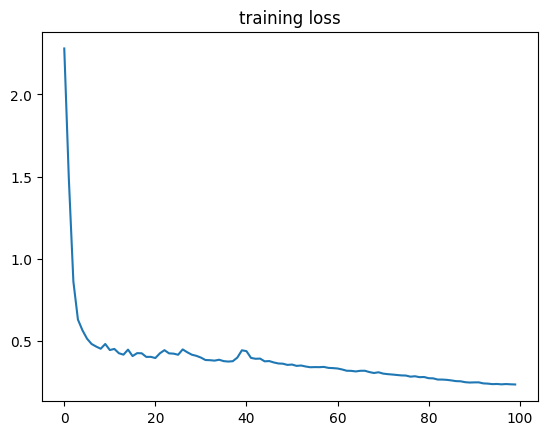

In [24]:
plt.plot(losses);
plt.title("training loss");

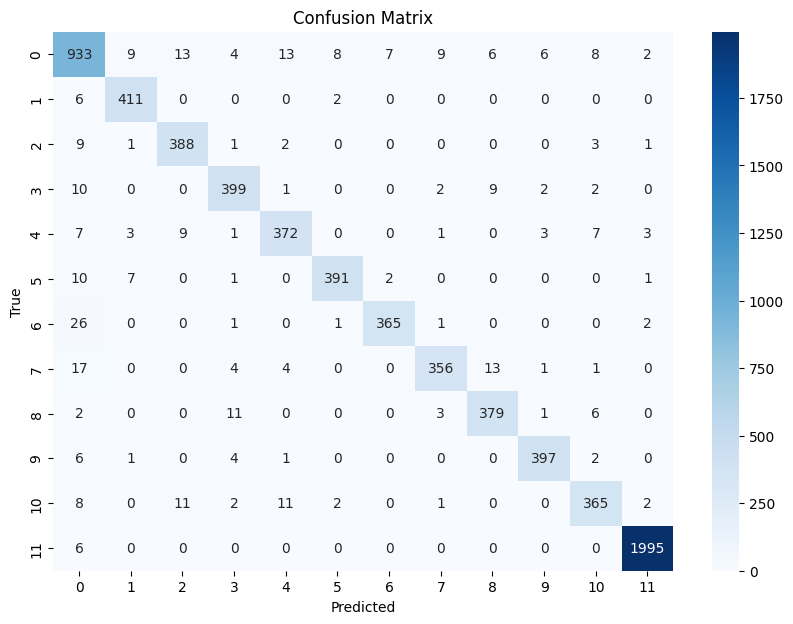

Accuracy for label '0': 91.65%
Accuracy for label '1': 98.09%
Accuracy for label '2': 95.80%
Accuracy for label '3': 93.88%
Accuracy for label '4': 91.63%
Accuracy for label '5': 94.90%
Accuracy for label '6': 92.17%
Accuracy for label '7': 89.90%
Accuracy for label '8': 94.28%
Accuracy for label '9': 96.59%
Accuracy for label '10': 90.80%
Accuracy for label '11': 99.70%


In [35]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 실제 라벨과 예측된 라벨을 저장할 리스트 초기화
true_labels = []
predicted_labels = []

# 테스트 셋을 순회하며 예측 수행
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    output = predict(waveform)
    output=output.cpu()[0]
    true_labels.append(utterance)
    predicted_labels.append(output)

# 라벨 리스트 정의 (unknown 라벨도 포함)
labels_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# 혼동 행렬 계산
cm = confusion_matrix(true_labels, predicted_labels, labels=labels_list)

# 각 라벨에 대한 정확도 계산
label_accuracies = {}
for i, label in enumerate(labels_list):
    true_positive = cm[i, i]
    total_samples = cm[i, :].sum()
    accuracy = true_positive / total_samples if total_samples > 0 else 0
    label_accuracies[label] = accuracy

# 혼동 행렬 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_list, yticklabels=labels_list)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# # 혼동 행렬을 텍스트 파일로 저장
# output_matrix_path = '/content/confusion_matrix.txt'
# np.savetxt(output_matrix_path, cm, fmt='%d', delimiter=',', header=','.join(labels_list), comments='')
# print(f"Confusion matrix saved to {output_matrix_path}")

# 각 라벨에 대한 정확도 출력
for label, accuracy in label_accuracies.items():
    print(f"Accuracy for label '{label}': {accuracy:.2%}")


0: unknown, 1: yes, 2: no, 3: up, 4: down, 5:left, 6:right, 7:on, 8:off, 9:stop, 10:go, 11:background_noise

In [37]:
# 학습이 끝난 신경망 모델
params = model.state_dict()
# model.prm라는 파일로 저장
torch.save(params, "model.prm", pickle_protocol = 5)

In [53]:
params = torch.load("model.prm", map_location = "cpu")
print(params.keys())
print(params['cnn_head.1.running_var'])

odict_keys(['total_ops', 'total_params', 'cnn_head.0.weight', 'cnn_head.1.weight', 'cnn_head.1.bias', 'cnn_head.1.running_mean', 'cnn_head.1.running_var', 'cnn_head.1.num_batches_tracked', 'BCBlocks.total_ops', 'BCBlocks.total_params', 'BCBlocks.0.total_ops', 'BCBlocks.0.total_params', 'BCBlocks.0.0.total_ops', 'BCBlocks.0.0.total_params', 'BCBlocks.0.0.f2.0.total_ops', 'BCBlocks.0.0.f2.0.total_params', 'BCBlocks.0.0.f2.0.block.0.weight', 'BCBlocks.0.0.f2.0.block.1.weight', 'BCBlocks.0.0.f2.0.block.1.bias', 'BCBlocks.0.0.f2.0.block.1.running_mean', 'BCBlocks.0.0.f2.0.block.1.running_var', 'BCBlocks.0.0.f2.0.block.1.num_batches_tracked', 'BCBlocks.0.0.f2.1.total_ops', 'BCBlocks.0.0.f2.1.total_params', 'BCBlocks.0.0.f2.1.block.0.weight', 'BCBlocks.0.0.f2.1.block.1.total_ops', 'BCBlocks.0.0.f2.1.block.1.total_params', 'BCBlocks.0.0.f2.1.block.1.ssnorm.weight', 'BCBlocks.0.0.f2.1.block.1.ssnorm.bias', 'BCBlocks.0.0.f2.1.block.1.ssnorm.running_mean', 'BCBlocks.0.0.f2.1.block.1.ssnorm.runnin

In [49]:
# 모델의 state_dict 출력
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# 옵티마이저의 state_dict 출력
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
total_ops 	 torch.Size([1])
total_params 	 torch.Size([1])
cnn_head.0.weight 	 torch.Size([16, 1, 3, 3])
cnn_head.1.weight 	 torch.Size([16])
cnn_head.1.bias 	 torch.Size([16])
cnn_head.1.running_mean 	 torch.Size([16])
cnn_head.1.running_var 	 torch.Size([16])
cnn_head.1.num_batches_tracked 	 torch.Size([])
BCBlocks.total_ops 	 torch.Size([1])
BCBlocks.total_params 	 torch.Size([1])
BCBlocks.0.total_ops 	 torch.Size([1])
BCBlocks.0.total_params 	 torch.Size([1])
BCBlocks.0.0.total_ops 	 torch.Size([1])
BCBlocks.0.0.total_params 	 torch.Size([1])
BCBlocks.0.0.f2.0.total_ops 	 torch.Size([1])
BCBlocks.0.0.f2.0.total_params 	 torch.Size([1])
BCBlocks.0.0.f2.0.block.0.weight 	 torch.Size([8, 16, 1, 1])
BCBlocks.0.0.f2.0.block.1.weight 	 torch.Size([8])
BCBlocks.0.0.f2.0.block.1.bias 	 torch.Size([8])
BCBlocks.0.0.f2.0.block.1.running_mean 	 torch.Size([8])
BCBlocks.0.0.f2.0.block.1.running_var 	 torch.Size([8])
BCBlocks.0.0.f2.0.block.1.num_batches_tracked 	 torch.Size

In [64]:
print(sp_transform(waveform).unsqueeze(0).shape)

torch.Size([1, 1, 40, 61])


In [68]:
import torch.onnx

dummy_data = torch.empty(1, 1, 40, 61, dtype = torch.float32).to('cuda')
torch.onnx.export(model, dummy_data, "output.onnx", export_params=True)

C:\Users\synnc\AppData\Local\Temp\ipykernel_1616\3257074213.py:217: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert h % self.spec_groups == 0


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



SymbolicValueError: Unsupported: ONNX export of operator adaptive_avg_pool2d, output size that are not factor of input size. Please feel free to request support or submit a pull request on PyTorch GitHub: https://github.com/pytorch/pytorch/issues  [Caused by the value '176 defined in (%176 : Long(2, strides=[1], device=cpu) = onnx::Constant[value=  1  61 [ CPULongType{2} ]]()
)' (type 'Tensor') in the TorchScript graph. The containing node has kind 'onnx::Constant'.] 

    Inputs:
        Empty
    Outputs:
        #0: 176 defined in (%176 : Long(2, strides=[1], device=cpu) = onnx::Constant[value=  1  61 [ CPULongType{2} ]]()
    )  (type 'Tensor')